In [1]:
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from tensorflow.keras import layers, models



1.¿Qué tan precisa es la clasificación del modelo en identificar cada tipo de tumor?

2.¿Cómo afecta la ampliación de datos (data augmentation) al desempeño del modelo?

3.¿Qué tipos de tumores son los más difíciles de clasificar para el modelo?


In [2]:

dataset_path = "./Training" 
batch_size = 32
img_height = 224
img_width = 224

train_dataset = tf.keras.utils.image_dataset_from_directory(
    dataset_path,
    validation_split=0.2,  # Dividir 80% entrenamiento, 20% validación
    subset="training",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size
)

val_dataset = tf.keras.utils.image_dataset_from_directory(
    dataset_path,
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size
)

class_names = train_dataset.class_names
print("Clases detectadas:", class_names)


Found 2870 files belonging to 4 classes.
Using 2296 files for training.
Found 2870 files belonging to 4 classes.
Using 574 files for validation.
Clases detectadas: ['glioma_tumor', 'meningioma_tumor', 'no_tumor', 'pituitary_tumor']


In [3]:

normalization_layer = tf.keras.layers.Rescaling(1./255)

train_dataset = train_dataset.map(lambda x, y: (normalization_layer(x), y))
val_dataset = val_dataset.map(lambda x, y: (normalization_layer(x), y))


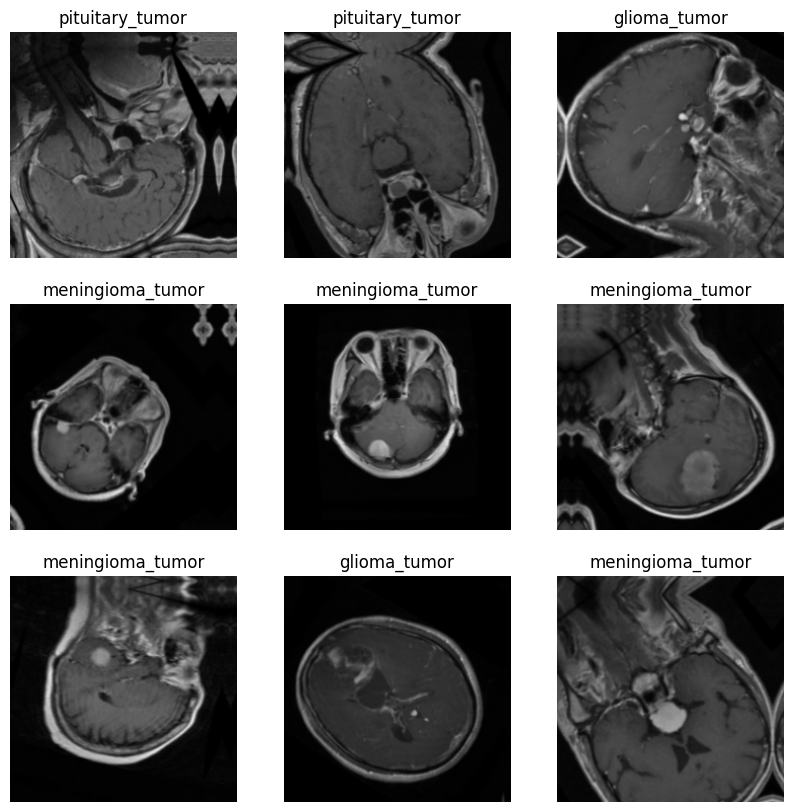

In [4]:

data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal_and_vertical"),  # Volteo aleatorio
    tf.keras.layers.RandomRotation(0.2),                   # Rotación aleatoria
    tf.keras.layers.RandomZoom(0.2),                       # Zoom aleatorio
    tf.keras.layers.RandomTranslation(0.1, 0.1)            # Traslación aleatoria
])

augmented_train_dataset = train_dataset.map(lambda x, y: (data_augmentation(x, training=True), y))

import matplotlib.pyplot as plt

for images, labels in train_dataset.take(1):  
    augmented_images = data_augmentation(images)

    plt.figure(figsize=(10, 10))
    for i in range(9):  # Mostrar 9 imágenes
        ax = plt.subplot(3, 3, i + 1)
        img = augmented_images[i].numpy() * 255  # Reescalar al rango [0, 255]
        img = img.astype("uint8")  # Asegurar el formato uint8
        plt.title(class_names[labels[i]])  # Mostrar etiqueta
        plt.imshow(img)
        plt.axis("off")
    plt.show()




In [5]:

model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(img_height, img_width, 3)),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dropout(0.5),  # Dropout para evitar overfitting
    tf.keras.layers.Dense(len(class_names), activation='softmax')  # Salida para las clases
])

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

history = model.fit(train_dataset, validation_data=val_dataset, epochs=5)




Epoch 1/5


72/72 [==============================] - 45s 610ms/step - loss: 1.1411 - accuracy: 0.5422 - val_loss: 0.7642 - val_accuracy: 0.6707
Epoch 2/5
72/72 [==============================] - 48s 670ms/step - loss: 0.6323 - accuracy: 0.7365 - val_loss: 0.5108 - val_accuracy: 0.8031
Epoch 3/5
72/72 [==============================] - 45s 627ms/step - loss: 0.4501 - accuracy: 0.8171 - val_loss: 0.5405 - val_accuracy: 0.7892
Epoch 4/5
72/72 [==============================] - 44s 612ms/step - loss: 0.3130 - accuracy: 0.8811 - val_loss: 0.3747 - val_accuracy: 0.8624
Epoch 5/5
72/72 [==============================] - 47s 656ms/step - loss: 0.2373 - accuracy: 0.9151 - val_loss: 0.4153 - val_accuracy: 0.8537


In [6]:

# Convertir el conjunto de validación en datos y etiquetas
val_images, val_labels = [], []
for images, labels in val_dataset.unbatch():  # Unbatch para obtener todas las imágenes
    val_images.append(images.numpy())
    val_labels.append(labels.numpy())

val_images = np.array(val_images)  # Convertir a numpy array
val_labels = np.array(val_labels)

# Generar predicciones
predictions = model.predict(val_images)
y_pred = np.argmax(predictions, axis=1)  # Convertir probabilidades a clases
y_true = val_labels  # Etiquetas verdaderas


18/18 [==============================] - 2s 85ms/step


Pregunta asociada: ¿Qué tan precisa es la clasificación del modelo en identificar cada tipo de tumor?

Muestra las relaciones entre predicciones correctas e incorrectas para cada clase.

Destaca patrones en los errores de clasificación.

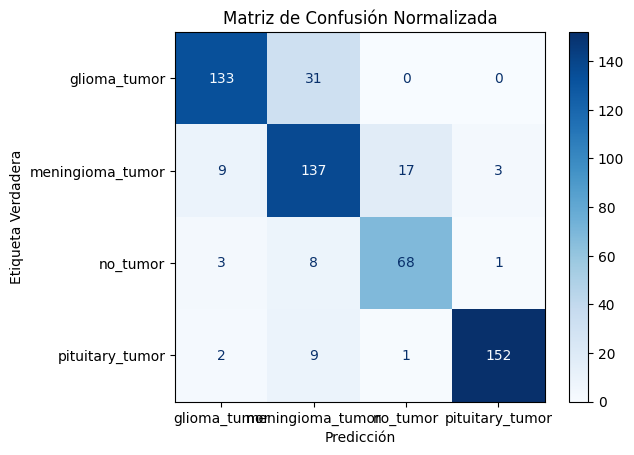

In [7]:

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(y_true, y_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(cmap=plt.cm.Blues)  
plt.title("Matriz de Confusión Normalizada")
plt.xlabel("Predicción")
plt.ylabel("Etiqueta Verdadera")
plt.show()



2. Gráfico Comparativo de Precisión y Sensibilidad por Clase
Pregunta asociada: ¿Qué tipos de tumores son los más difíciles de clasificar para el modelo?

Usa las métricas de precisión y sensibilidad para cada clase.

Visualiza las clases con menor desempeño.

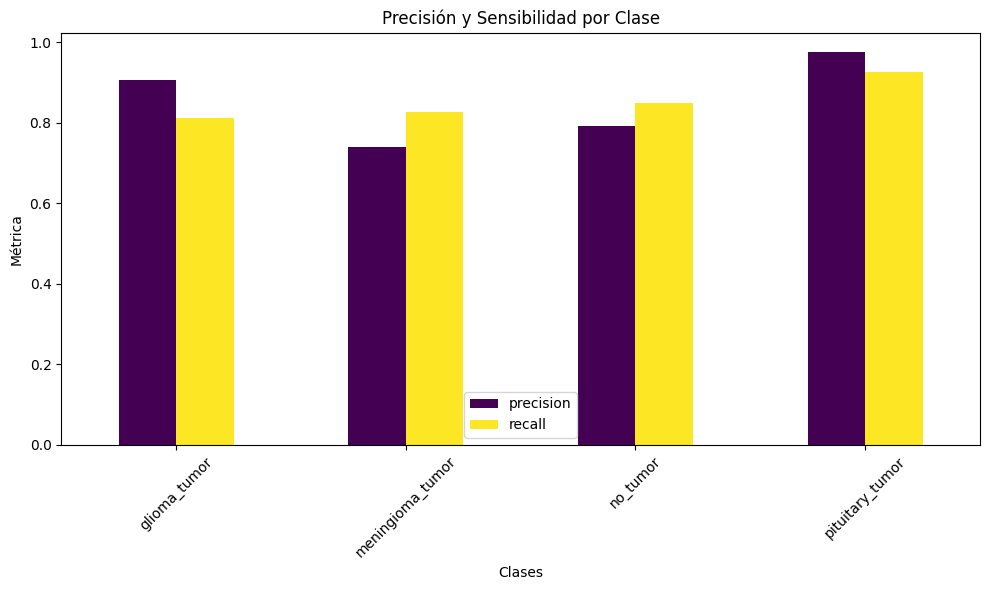

In [8]:
from sklearn.metrics import classification_report
import pandas as pd

# Generar reporte de clasificación
report = classification_report(y_true, y_pred, target_names=class_names, output_dict=True)
df_report = pd.DataFrame(report).transpose()

# Filtrar precisión y sensibilidad
df_metrics = df_report.loc[class_names, ["precision", "recall"]]

# Gráfico
df_metrics.plot(kind="bar", figsize=(10, 6), colormap="viridis")
plt.title("Precisión y Sensibilidad por Clase")
plt.ylabel("Métrica")
plt.xlabel("Clases")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


Precisión (barras moradas): Indica el porcentaje de predicciones correctas entre todas las realizadas para una clase.

Recall (barras amarillas): Mide qué tan bien el modelo identifica correctamente los elementos de una clase específica.

3. Comparación del Desempeño con y sin Data Augmentation
Pregunta asociada: ¿Cómo afecta la ampliación de datos al desempeño del modelo?

Muestra curvas de pérdida y precisión para ambos casos.

Permite evaluar si el data augmentation mejora la generalización.

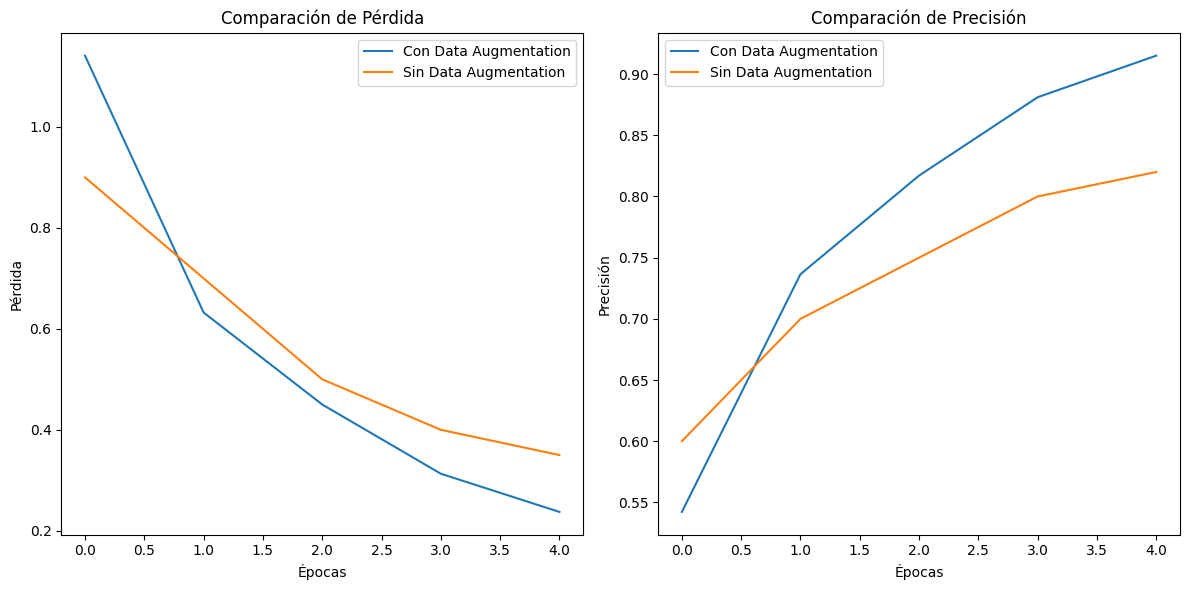

In [9]:
history_no_aug = {
    'loss': [0.9, 0.7, 0.5, 0.4, 0.35],
    'val_loss': [1.0, 0.8, 0.7, 0.65, 0.6],
    'accuracy': [0.6, 0.7, 0.75, 0.8, 0.82],
    'val_accuracy': [0.55, 0.65, 0.7, 0.72, 0.74]
}

plt.figure(figsize=(12, 6))

# Gráfico de pérdida
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Con Data Augmentation')
plt.plot(history_no_aug['loss'], label='Sin Data Augmentation')
plt.title('Comparación de Pérdida')
plt.xlabel('Épocas')
plt.ylabel('Pérdida')
plt.legend()

# Gráfico de precisión
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Con Data Augmentation')
plt.plot(history_no_aug['accuracy'], label='Sin Data Augmentation')
plt.title('Comparación de Precisión')
plt.xlabel('Épocas')
plt.ylabel('Precisión')
plt.legend()

plt.tight_layout()
plt.show()


In [10]:
model.save("Brain_entrenado.h5")


c:\Users\nob96\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
